# Sujet 5 : Prévoir la pollution de l'air à partir de données météo

Il s’agit de prévoir la concentration en polluants dans différentes villes françaises à partir de données météorologiques (vent, précipitations, etc.).

Les données météorologiques sont issues du [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/home) du programme Copernicus.

La variable à prédire est la concentration en particules fines dites [PM<sub>2.5</sub>](https://www.airparif.asso.fr/les-particules-fines), c'est-à-dire dont le diamètre est inférieur à 2.5 μm. Ces particules sont néfastes pour la santé.

Le problème peut être traité en appliquant des algorithmes de machine learning supervisé tels que la régression logistique, les forêts aléatoires, les Gradient Boosted Trees ou encore les réseaux de neurones.

## Import des packages et chargement des données

On commence par installer et importer les packages nécessaires.

In [1]:
install.packages('aws.s3')
install.packages('mlr3verse')
remotes::install_github("mlr-org/mlr3extralearners")

also installing the dependency ‘aws.signature’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependencies ‘PRROC’, ‘cluster’, ‘gridExtra’, ‘checkmate’, ‘lgr’, ‘mlbench’, ‘mlr3measures’, ‘palmerpenguins’, ‘clue’, ‘clusterCrit’, ‘viridis’, ‘mlr3’, ‘bbotk’, ‘mlr3cluster’, ‘mlr3data’, ‘mlr3filters’, ‘mlr3fselect’, ‘mlr3hyperband’, ‘mlr3learners’, ‘mlr3misc’, ‘mlr3pipelines’, ‘mlr3tuning’, ‘mlr3tuningspaces’, ‘mlr3viz’, ‘paradox’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done




parallelly (1.31.1 -> 1.32.0) [CRAN]
future     (1.25.0 -> 1.26.1) [CRAN]


Installing 2 packages: parallelly, future

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



* checking for file ‘/tmp/RtmpPdDPYQ/remotes4c9c22eac3/mlr-org-mlr3extralearners-6166926/DESCRIPTION’ ... OK
* preparing ‘mlr3extralearners’:
* checking DESCRIPTION meta-information ... OK
* installing the package to process help pages
* saving partial Rd database
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Removed empty directory ‘mlr3extralearners/vignettes’
* looking to see if a ‘data/datalist’ file should be added
* building ‘mlr3extralearners_0.5.38.tar.gz’



In [2]:
# Chargement des données
library (aws.s3)

# Manipulation des données
library(tidyverse)

# Visualisation des données
library(ggplot2)

# Machine learning
library(mlr3verse)
library(mlr3extralearners)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: mlr3



Les données sont stockées sur un serveur distant nommé S3. On définit le chemin d'accès au fichier.

In [3]:
bucket <- "projet-funathon"
filepath <- "diffusion/2022/Sujet 5/donnees_meteo_pollution.csv"

On peut finalement lire le fichier

In [4]:
df <- s3read_using(read.csv, object = filepath, bucket = bucket, opts = list('region'=''))

## Statistiques descriptives

Les données concernent la période 2013-2021 et couvrent les villes de Paris, Lyon, Rennes, Troyes, Reims, Marseille, Montpellier, Toulouse, Bordeaux, Lorient, Limoges, ainsi que la forêt de Chizé. Cependant, la concentration en particules fines (la variable cible) n'est pas disponible pour toutes les villes sur toute la période. Cela dépend de la date de mise en service des stations de mesure.

Les variables explicatives disponibles sont les suivantes :
- blh : "boundary layer height", c'est la hauteur de la couche limite, c'est-à-dire la hauteur de la partie la plus basse de l'atmosphère
- msl : "mean sea level pressure", c'est la pression moyenne au niveau de la mer
- t2m : température à 2m de la surface
- tcc : "total cloud cover", c'est la proportion du ciel couvert par des nuages
- tp : précipitations totales
- u10 : vitesse du vent allant vers l'est, à 10 mètres de la surface (peut être négatif pour un vent vers l'ouest)
- v10 : vitesse du vent allant vers le nord, à 10 mètres de la surface (peut être négatif pour un vent vers le sud)

In [5]:
names(df)

[1] "station"  "geometry" "date"     "blh"      "v10"      "t2m"     
 [7] "tcc"      "u10"      "tp"       "msl"      "pm2.5"

On peut voir à quoi ressemblent les données en affichant les 5 premières lignes.

In [6]:
head(df)

station geometry                  date       blh       v10        t2m     
1 Rennes  POINT (-1.66586 48.10861) 2019-12-05   93.1441  0.8436788 273.3864
2 Rennes  POINT (-1.66586 48.10861) 2020-02-08  608.7348  2.8796360 282.4664
3 Rennes  POINT (-1.66586 48.10861) 2019-12-22 1262.9279  0.8374958 282.6172
4 Rennes  POINT (-1.66586 48.10861) 2019-11-03  889.6064  0.5608260 284.6610
5 Rennes  POINT (-1.66586 48.10861) 2020-02-26 1128.0018 -0.7360675 279.1199
6 Rennes  POINT (-1.66586 48.10861) 2019-07-13  796.5258 -3.5923126 292.5630
  tcc      u10        tp           msl       pm2.5
1 79.97729  0.6136506 1.986821e-07 102389.80 37.7 
2 82.40255  2.1103294 1.981258e-04 101966.34 12.7 
3 55.09860  7.0141506 8.684397e-05  99428.27 13.4 
4 82.73901  3.1675446 5.463560e-04  98569.53  9.4 
5 73.31263  5.1786633 1.833836e-05 101240.10 11.8 
6 25.82296 -0.4566682 8.940697e-07 102028.63  8.4

La fonction méthode `summary` permet d'afficher des statistiques sur les colonnes numériques du dataframe.

In [7]:
summary(df)

   station            geometry             date                blh        
 Length:39444       Length:39444       Length:39444       Min.   :  25.0  
 Class :character   Class :character   Class :character   1st Qu.: 360.0  
 Mode  :character   Mode  :character   Mode  :character   Median : 535.4  
                                                          Mean   : 559.8  
                                                          3rd Qu.: 720.7  
                                                          Max.   :2035.3  
                                                                          
      v10                 t2m             tcc              u10          
 Min.   :-11.68963   Min.   :266.9   Min.   :  0.00   Min.   :-13.8455  
 1st Qu.: -1.75466   1st Qu.:281.8   1st Qu.: 36.02   1st Qu.: -0.8817  
 Median : -0.09589   Median :286.1   Median : 64.15   Median :  0.7283  
 Mean   : -0.04536   Mean   :286.4   Mean   : 58.73   Mean   :  0.7971  
 3rd Qu.:  1.68610   3rd Qu.:291.1 

On peut aussi calculer séparément les grandeurs qui nous intéressent, comme la moyenne de la variable cible.

In [8]:
mean(df$pm2.5, na.rm = TRUE)

[1] 20.92318

On va tracer l'évolution de la concentration en particules fines à Paris et Lyon au cours du temps. Pour cela, il faut d'abord isoler les données de chaque ville, puis transformer le champ date, stocké comme une chaîne de caractère, en un champ temporel.

In [14]:
df_paris <- df %>%
            filter(station == "Paris") %>% 
            mutate(date = as.Date(date)) %>% 
            drop_na(pm2.5)

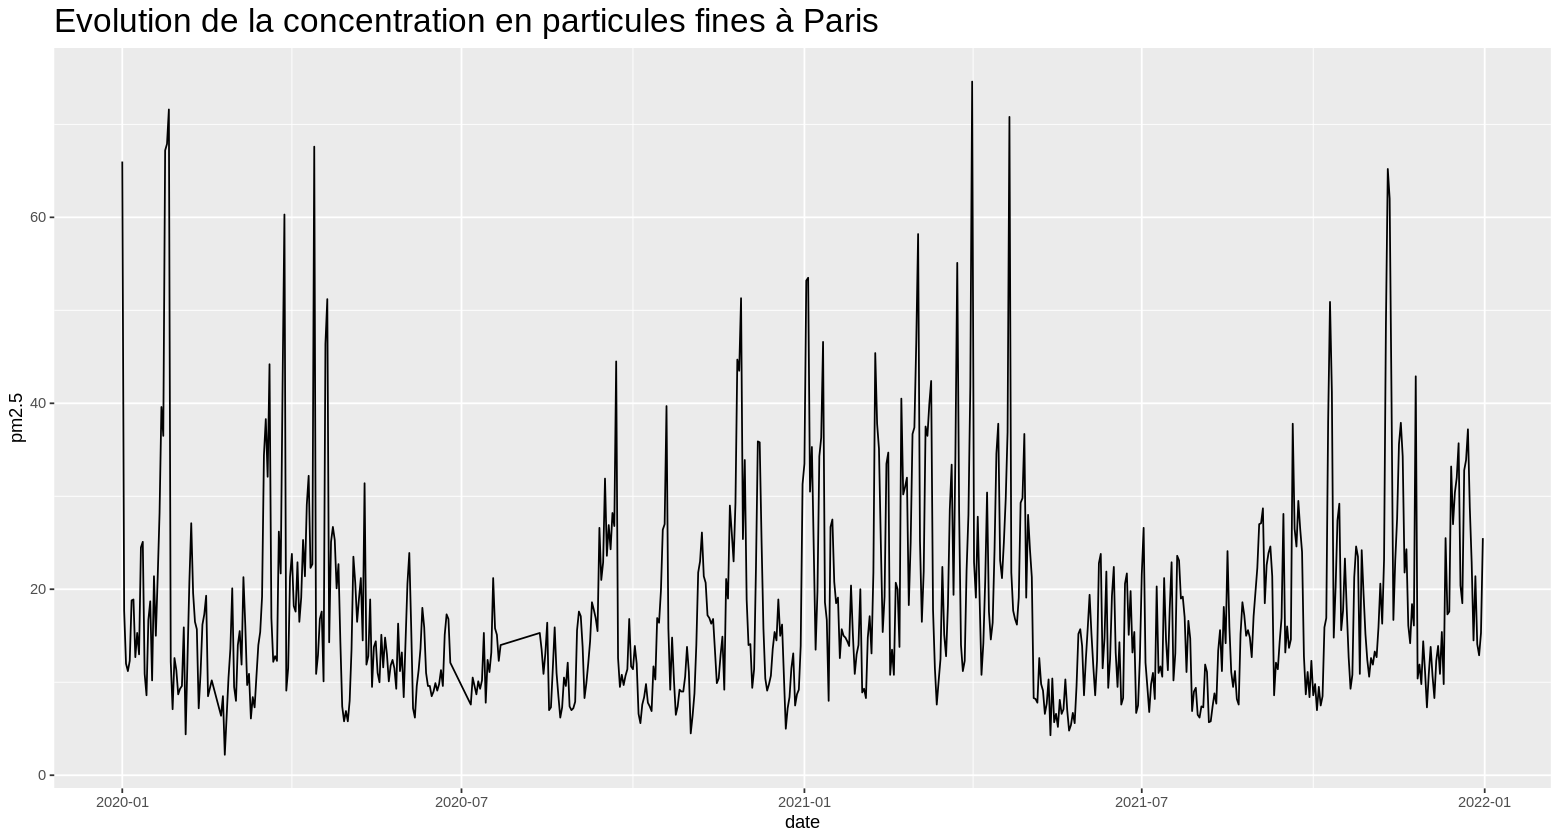

In [15]:
options(repr.plot.width=13, repr.plot.height=7)
ggplot(df_paris, aes(x=date, y=pm2.5)) +
  geom_line() +
  ggtitle("Evolution de la concentration en particules fines à Paris") +
  theme(plot.title = element_text(size = 20))

L'historique est plus grand pour Lyon, mais on ne dispose pas des données pour l'année 2018.

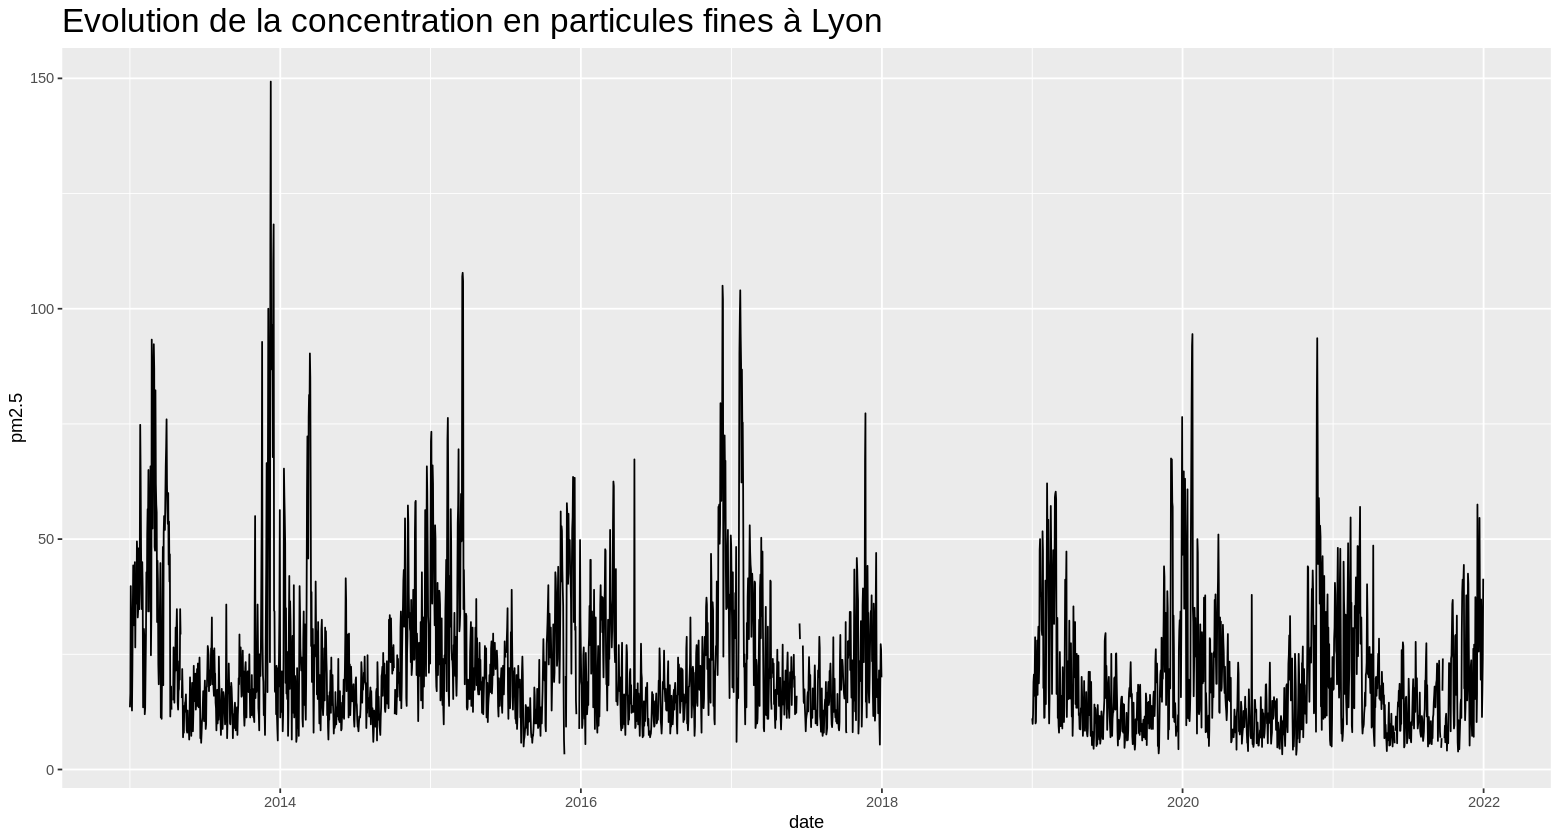

In [13]:
df_lyon <- df %>%
            filter(station == "Lyon") %>% 
            mutate(date = as.Date(date))
ggplot(df_lyon, aes(x=date, y=pm2.5)) +
  geom_line() +
  ggtitle("Evolution de la concentration en particules fines à Lyon") +
  theme(plot.title = element_text(size = 20))

On regarde si les données contiennent des valeurs manquantes. Ici, il n'y a que la variable cible qui en a, lorsque l'on ne dispose pas de mesures de pollution pour une ville et un jour donné.

In [16]:
df %>% summarise_all(~ sum(is.na(.)))

station geometry date blh v10 t2m tcc u10 tp msl pm2.5
1 0       0        0    0   0   0   0   0   0  0   15555

## Premiers modèles

Pour entraîner les modèles de machine learning, on va utiliser la librairie [_mlr3_](https://mlr3book.mlr-org.com/index.html) qui propose une syntaxe commune pour un grand ensemble de modèles différents. Elle contient aussi des fonctions auxiliaires de preprocessing ou d'évaluation des résultats.

Cette librairie est assez récente et elle est en développement actif. Il existe toutefois d'autres librairies dédiées au machine learning en R, comme _caret_ ou _tidymodels_.

#### Gestion des valeurs manquantes

On commence par gérer les valeurs manquantes. Ici, pas d'imputation possible puisque c'est la variable cible qui est manquante. On supprime donc les lignes concernées.

In [17]:
df <- df %>% drop_na(pm2.5)

#### Création des échantillons de test et d'entraînement

Dans mlr3, il faut d'abord définir le type de tâche à effectuer. Ici, on essaie de prédire une variable continue, c'est donc une tâche de régression. On la définit via la fonction `as_task_regr`, en lui fournissant les données, en précisant quelle est la variable cible (ici _pm2.5_) et en lui donnant un nom (ici "pollution").

In [18]:
task = as_task_regr(df %>% select(blh, msl, t2m, tcc, tp, u10, v10, pm2.5), target = "pm2.5", id = "pollution")

Puis on sépare les données en deux échantillons : 
- un échantillon d'entraînement que l'on va fournir aux modèles pour les calibrer,
- un échantillon de test pour évaluer les performances des modèles et les comparer.

L'échantillon d'entraînement représente 80% des lignes, et l'échantillon de test les 20% restants.

On utilise une graine pour initialiser le générateur de nombres aléatoires, par l'intermédiaire de la fonction `set.seed`, arbitrairement fixée à 42 ici (tout autre nombre aurait fonctionné). Cette graine permet de rendre le découpage des échantillons déterministe. Sans elle, le découpage serait différent à chaque exécution, ce qui ferait fluctuer les performances du modèle.

In [19]:
set.seed(42)
train_set <- sample(task$nrow, 0.8 * task$nrow)
test_set <- setdiff(seq_len(task$nrow), train_set)

#### Régression linéaire

On commence par une simple régression linéaire. C'est toujours une bonne base de comparaison dans un problème de régression (prédiction d'une variable continue). Les modèles s'entraînent via la méthode `train`.

In [20]:
learner <- lrn("regr.lm")
learner$train(task, row_ids = train_set)
print(learner$model)


Call:
stats::lm(formula = task$formula(), data = task$data())

Coefficients:
(Intercept)          blh          msl          t2m          tcc           tp  
 125.768623    -0.015157     0.001361    -0.804886    -0.064025   -72.832481  
        u10          v10  
  -0.506508    -0.260020  



Notre premier modèle est entraîné ! On peut maintenant effectuer les prédictions sur l'échantillon de test.

In [21]:
predictions = learner$predict(task, row_ids = test_set)

Il nous reste à mesurer ses performances. Plusieurs mesures existent. Ici on utilise la racine de l'erreur quadratique moyenne, souvent dénotée par son acronyme anglais RMSE.

In [22]:
predictions_dt = as.data.table(predictions)
RMSE = sqrt(mean((predictions_dt[, truth] - predictions_dt[, response]) ^2))
print(RMSE)

[1] 12.53385


mlr3 permet également de calculer facilement diverses mesures de performance, dont la RMSE.

In [23]:
measure = msr("regr.rmse")
RMSE_avec_mlr3 = predictions$score(measure)
print(RMSE)

[1] 12.53385


#### Forêt aléatoire

Essayons maintenant un modèle de forêt aléatoire. Il s'agit d'un modèle reposant sur un ensemble (parfois très grand !) d'arbres de décision. Notre forêt contient 100 arbres (c'est le rôle de l'hyperparamètre _n_tree_). Il y a de l'aléatoire dans la construction des arbres, on utilise donc ici aussi une graine pour la reproductibilité de l'entraînement.

In [24]:
learner <- lrn("regr.randomForest", ntree = 100)
learner$train(task, row_ids = train_set)
print(learner$model)


Call:
 randomForest(formula = formula, data = data, ntree = 100L) 
               Type of random forest: regression
                     Number of trees: 100
No. of variables tried at each split: 2

          Mean of squared residuals: 170.386
                    % Var explained: 32.29


On peut à nouveau effectuer les prédictions sur l'échantillon de test et mesurer les résultats.

In [25]:
predictions = learner$predict(task, row_ids = test_set)

In [26]:
measure = msr("regr.rmse")
RMSE = predictions$score(measure)
print(RMSE)

regr.rmse 
 11.66028 


L'erreur moyenne de nos prédictions sur la concentration en particules fines est donc de l'ordre de 12 μm. C'est mieux que la régression linéaire, mais cela reste très mauvais (pour rappel, la concentration moyenne sur notre jeu de données est de l'ordre de 21 μm). Il y a du travail pour améliorer notre modèle !

## Comment poursuivre ?

- Ajouter des variables explicatives (ex : le jour de la semaine pour tenir compte de la variation du trafic routier)
- Essayer d'autres modèles (Gradient Boosted Trees, SVM, etc.)
- Faire varier les hyperparamètres des modèles
- Interpréter les résultats d'un modèle (importance des variables, disribution des erreurs, etc.)
- Prendre en compte la composante temporelle
- Prendre en compte la composante géographique en distinguant les stations de mesure (Comment ? Un modèle par station ou un modèle global avec la station comme variable explicative ?)